In [1]:
# comparison of splines to other datasets:
# - in the transect (AWIPIES from geoslurp database)
# https://github.com/FESOM/pyfesom/blob/master/notebooks/plot_transect.ipynb
# - visualize as T/S trend (trend for every level and point, coestimate annual and semiannual, maybe smth else? use uncertainties)
# - time period: 01.2007-12.2016?
# - visualize as trend of steric height

# https://icdc.cen.uni-hamburg.de/en/ishii.html
# https://icdc.cen.uni-hamburg.de/en/en4.html

In [2]:
import sys
sys.path.append("../")

import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
from geopy import distance
import pyfesom as pf
import scipy.io
from netCDF4 import *
import julian
import datetime
from datetime import timedelta
import paramTSz as func
import stericheight as sth
from matplotlib import cm
%matplotlib inline

In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [3]:
# read ocean bottom pressure data (https://github.com/strawpants/schroeter-southatlantic-2019/tree/master/analysis/data)
dataOBP = scipy.io.loadmat('OBPv2.mat')
degE = dataOBP['degE'] 
degN = dataOBP['degN'] 
P_oc = dataOBP['OPRES']
time = dataOBP['OTIME']

In [4]:
basedir = '/home/najona/swift.dkrz.de'

# load the mesh
meshpath  = basedir+'/COREII/'
mesh = pf.load_mesh(meshpath, usepickle=True)

/home/najona/swift.dkrz.de/COREII/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /home/najona/swift.dkrz.de/COREII/pickle_mesh_py3


In [5]:
# load data for one year
fl = Dataset(basedir+'/COREII_data/fesom.1951.oce.mean.nc')
fl.variables['temp'].shape

(12, 3668773)

In [6]:
# select one month
data = fl.variables['temp'][0,:]

In [7]:
lon_start = np.min(degE) 
lat_start = np.min(degN) 
lon_end   = np.max(degE) 
lat_end   = np.max(degN) 

npoints = 80

In [8]:
lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints=npoints)
labeles = [str(abs(int(x)))+"$^{\circ}$S" for x in lonlat[7::8][:,1]]
dist = pf.transect_get_distance(lonlat) # gets distances between starting point and present point

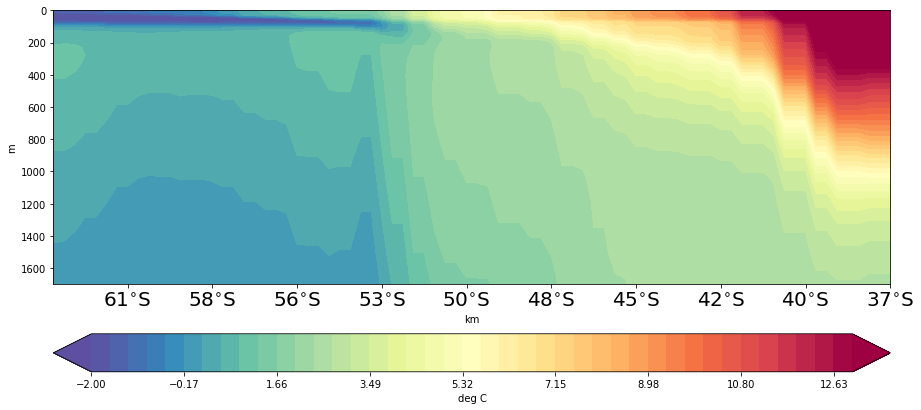

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
image = pf.plot_transect(data, mesh, 
                         lon_start,
                         lat_start,
                         lon_end,
                         lat_end,
                         npoints=npoints,
                         levels = np.round(np.linspace(-2, 13, 42),2),
                         cmap=cm.Spectral_r,
                         maxdepth =2000,
                         title = '',
                         ncols=1,
                         figsize=(5,10),
                        ax = ax
                        )
cb = fig.colorbar(image, orientation='horizontal', ax=ax, pad=0.13)
cb.set_label('deg C')
ax.xaxis.set_ticks(dist[7::8])
ax.set_xticklabels(labeles, size=20);

### T, S trend (for every level and point)

In [10]:
def compareData(OBP_point, level, dataset):
    data_list = []
    for year in range(7,17):
        if year < 10:
            year = '0'+str(year)
        for month in range(1,13):
            if month < 10:
                month = '0'+str(month)
            if dataset == 'en4-gouretski':
                en4 = Dataset('/home/najona/EN.4.2.1.analyses.g10.20' +str(year)+ '/EN.4.2.1.f.analysis.g10.20' +str(year)+
                      str(month)+'.nc')
            if dataset == 'en4-levitus':
                en4 = Dataset('/home/najona/EN.4.2.1.analyses.l09.20' +str(year)+ '/EN.4.2.1.f.analysis.l09.20' +str(year)+
                      str(month)+'.nc')
            
            T = en4.variables['temperature'][:]  # temperature (in K)
            T = T - 273.15                       # temperature (in degC)
            SAL = en4.variables['salinity'][:]   # salinity
            depth = en4.variables['depth'][:]    # depth
            lat = en4.variables['lat'][:]
            long = en4.variables['lon'][:]
            t = en4.variables['time'][:]         # units: days since 1800-01-01 00:00:00
        
            if year == '07' and month == '01':
                d = []
                la_list = []
                lo_list = []
                for lo in range(len(long)):
                    for la in range(len(lat)):
                        d.append(distance.distance((degN[OBP_point], degE[OBP_point]), (lat[la], long[lo])))
                        la_list.append(lat[la])
                        lo_list.append(long[lo])
                idx = np.argmin(d)

            data_monthly = ['20'+str(year), month, la_list[idx], lo_list[idx], T[0,level,np.where(lat==la_list[idx]),
                            np.where(long==lo_list[idx])], depth[level], SAL[0,level,np.where(lat==la_list[idx]),
                            np.where(long==lo_list[idx])], t]
            data_list = np.append(data_list, data_monthly)
    data_list = data_list.reshape(120,8)
            
    w = 2*math.pi/365 # frequency
    p = 2             # degree of harmonic function

    A_harm = func.getA_harm(data_list[:,-1].astype(float), w, p)
    xS_harm_T,lS_harm_T,v_harm_T,rp_harm_T = func.linearGMM(A_harm, data_list[:,4].astype(float))
    xS_harm_S,lS_harm_S,v_harm_S,rp_harm_S = func.linearGMM(A_harm, data_list[:,6].astype(float))

    x_Raster = np.arange(data_list[0,-1], data_list[-1,-1], 10)
    date_ref = datetime.datetime.strptime('1800-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
    jd_ref = julian.to_jd(date_ref, fmt='jd')
    time = np.array([julian.from_jd(x_Raster[i] + jd_ref) for i in range(len(x_Raster))])

    time2 = np.array([julian.from_jd(data_list[:,-1].astype(float)[i] + jd_ref) for i in range(len(data_list[:,-1].astype(float)))])

    Ax = func.getA_harm(x_Raster, w, p)
    Ax_S = func.getA_harm(x_Raster, w, p)
    f_Raster_T = Ax.dot(xS_harm_T)
    f_Raster_S = Ax_S.dot(xS_harm_S)

    fig, ax = plt.subplots()
    plt.title('T trend at OBP point '+str(OBP_point)+', level '+str(level)+',  ' +str(np.round(degN[OBP_point],2))+' long, '
              +str(np.round(degE[OBP_point],2))+' lat')
    ax.plot(time, f_Raster_T, 'k')
    ax.plot(time2, data_list[:,4], 'b.')
    plt.xlabel("year")
    plt.ylabel("Temperature [°C]")
    plt.gcf().autofmt_xdate()
    plt.text(1,1, dataset+'\n'+'trend: '+format(xS_harm_T[1], '.3g')+'°C', ha='right', va='top', transform=ax.transAxes)
    plt.show()

    fig, ax = plt.subplots()
    plt.title('S trend at OBP point '+str(OBP_point)+', level '+str(level)+',  ' +str(np.round(degN[OBP_point],2))+' long, '
              +str(np.round(degE[OBP_point],2))+' lat')
    ax.plot(time, f_Raster_S, 'k')
    ax.plot(time2, data_list[:,6], 'r.')
    plt.xlabel("year")
    plt.ylabel("Salinity")
    plt.gcf().autofmt_xdate()
    plt.text(1,1, dataset+'\n'+'trend: '+format(xS_harm_S[1], '.3g'), ha='right', va='top', transform=ax.transAxes)
    plt.show()

    return xS_harm_T[1], xS_harm_S[1] #trend

/home/najona/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


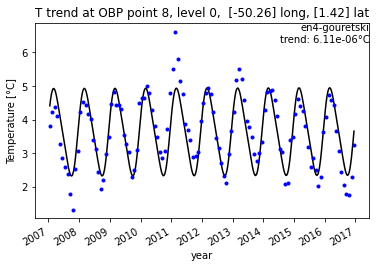

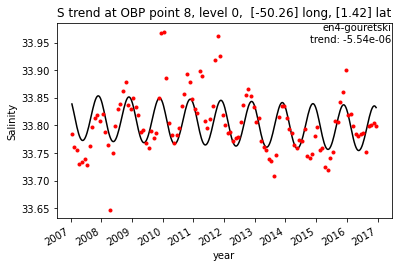

/home/najona/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


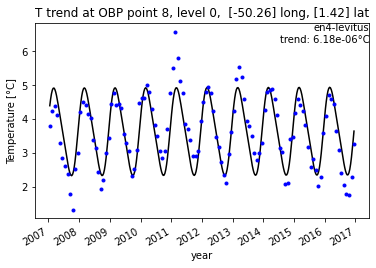

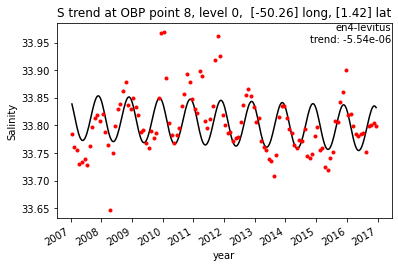

In [11]:
trend_T, trend_S = compareData(8, 0, 'en4-gouretski')
trend_T, trend_S = compareData(8, 0, 'en4-levitus')

In [12]:
# trend sth
def trend_sth(OBP_point, level, dataset):
    data_list = []
    for year in range(7,17):
        if year < 10:
            year = '0'+str(year)
        for month in range(1,13):
            if month < 10:
                month = '0'+str(month)
            if dataset == 'en4-gouretski':
                en4 = Dataset('/home/najona/EN.4.2.1.analyses.g10.20' +str(year)+ '/EN.4.2.1.f.analysis.g10.20' +str(year)+
                      str(month)+'.nc')
            if dataset == 'en4-levitus':
                en4 = Dataset('/home/najona/EN.4.2.1.analyses.l09.20' +str(year)+ '/EN.4.2.1.f.analysis.l09.20' +str(year)+
                      str(month)+'.nc')
            
            T = en4.variables['temperature'][:]  # temperature (in K)
            T = T - 273.15                       # temperature (in degC)
            SAL = en4.variables['salinity'][:]   # salinity
            depth = en4.variables['depth'][:]    # depth
            lat = en4.variables['lat'][:]
            long = en4.variables['lon'][:]
            t = en4.variables['time'][:]         # units: days since 1800-01-01 00:00:00
        
            if year == '07' and month == '01':
                d = []
                la_list = []
                lo_list = []
                for lo in range(len(long)):
                    for la in range(len(lat)):
                        d.append(distance.distance((degN[OBP_point], degE[OBP_point]), (lat[la], long[lo])))
                        la_list.append(lat[la])
                        lo_list.append(long[lo])
                idx = np.argmin(d)

            data_monthly = ['20'+str(year), month, la_list[idx], lo_list[idx], T[0,:,np.where(lat==la_list[idx]),
                            np.where(long==lo_list[idx])], depth, SAL[0,:,np.where(lat==la_list[idx]),
                            np.where(long==lo_list[idx])], t]
            data_list = np.append(data_list, data_monthly)
    data_list = data_list.reshape(120,8)

    dh = []
    for i in range(len(data_list)): 
        dh.append(sth.TSz_to_h_steric2(data_list[i,4][0], data_list[i,6][0], -data_list[i,5], data_list[i,2], data_list[i,3]))
        
    date_ref = datetime.datetime.strptime('1800-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
    jd_ref = julian.to_jd(date_ref, fmt='jd')
    time = np.array([julian.from_jd(data_list[i,-1] + jd_ref) for i in range(len(data_list[:,-1]))])

    plt.figure()
    plt.plot(time, dh)
    plt.gcf().autofmt_xdate()
    plt.xlabel('year')
    plt.ylabel('steric height change [m]')
    plt.show()
    
    return dh

/home/najona/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


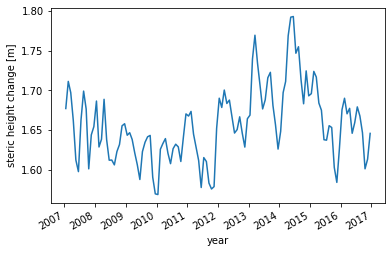

In [13]:
h_steric = trend_sth(8, 0, 'en4-gouretski')